Example 1
=========

Overview
--------

The material in this notebook covers four topics: binomial
distributions, the central limit theorem, outliers in data and invalid
model assumptions. You will have approximately 15 minutes to work
through each part, after which we will go through the answers together.
Some questions may be challenging, feel free to skip harder questions on
a first reading if you feel they will take too much time during the
tutorial.

This notebook is available on github
[here](https://github.com/aezarebski/aas-extended-examples). If you find
errors or would like to suggest an improvement, feel free to create an
issue.

Introduction
------------

In this lab we will look at the binomial distribution, central limit
theorem, and analyse two data sets consisting of a number of coin
tosses. We will look for a bias in the results of coin flips. Some of
the questions are open-ended by design. Partial solutions will be
distributed at the end of the session.

As usual we will start by importing some useful libraries.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

Parameter estimation of the binomial distribution
-------------------------------------------------

We want to make an *estimate* the probability that a coin comes up
heads. We also want to understand the level of confidence we have in
this estimate; we use a *confidence interval* (CI) to describe the range
of values we are confident the \"true\" probability of heads lies
within.

Binomial random variables can be used to model the number of times a
coin comes up heads when flipped $n$ times. Let $X$ be a binomial random
variable (RV) representing the number of heads that are observed when a
coin is flipped $n$ times and the probability of coming up heads is $p$.
We assume that $n$ is known but $p$ is unknown.

The expected value of $X$, ie the average number of times that the coin
comes up heads, is $np$. So a simple way to estimate $p$ is to divide
the number of heads, $X$, by the number of flips, $n$. This gives the
estimate

$$
\hat{p} = X / n.
$$

This estimator is called the [the method of
moments](https://en.wikipedia.org/wiki/Method_of_moments_(statistics)).
This is also an example of a maximum likelihood estimate (MLE).

Given an estimator, such as $\hat{p}$, we usually want to quantify the
uncertainty. The *Wald method* is one way to get the $95\%$ CI. It is a
very simple method, but it is acceptable when we have lots of data. The
estimated standard error of $\hat{p}$ is $\sqrt{\hat{p}(1-\hat{p})/n}$,
so the Wald CI is given by

$$
\hat{p} \pm z \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}
$$

where $z$ is the appropriate quantile of the standard normal
distribution. In the case of a $95\%$ distribution this value is $1.96$.

The details are all given on the
[Wikipedia](https://en.wikipedia.org/wiki/Binomial_distribution#Estimation_of_parameters)
but there is also a reasonably clear description in [All of
Statistics](https://link.springer.com/book/10.1007/978-0-387-21736-9)
which you can get via SOLO. You can also find reasonable treatments of
Wald CIs in both of those resources.

### Question

State the limitations on the estimator we are using for the CI.

### Answer

The Wald estimate assumes you have enough data to justify an asymptotic
solution so is unlikely to be accurate for small datasets.

### Question

Implement a function called `wald_estimate_and_ci` which takes two
arguments: `num_trials` which is $n$ in the description above, and
`num_success` which is $X$ above. The function should return
`(p_hat,(wald_lower,wald_upper))` where `p_hat` is $\hat{p}$ and
`wald_x` are the limits on the $95\%$ CI using the Wald method.

### Answer

In [2]:
def wald_estimate_and_ci(num_trials, num_success):
    p_hat = num_success / num_trials
    z = 1.96
    delta = z * np.sqrt(p_hat * (1 - p_hat) / num_trials)
    return (p_hat,(p_hat - delta, p_hat + delta))

### Question

Simulate a binomial random variable with $n=100$ and $p=0.6$. Then use
the value and the `wald_estimate_and_ci` function to see how well you
can estimate $p$. Write a couple of sentences to explain this.

Recall that in a previous example we have looked at how to simulate
random variables using `scipy.stats`.

### Question

Repeat the process from the previous question 100000 times and see what
proportion of the CIs capture the true value of $p$. Is it what you
expect? Write a couple of sentences to explain what you found.

### Answer

In [3]:
num_trials = 100
num_repeats = 100000
rand_xs = stats.binom.rvs(n = num_trials, p = 0.6, size = num_repeats)

def ci_contains_value(ci, p):
    lower,upper = ci
    return lower < p and p < upper

in_ci_count = 0
for x in rand_xs:
    _, ci = wald_estimate_and_ci(num_trials, x)
    if ci_contains_value(ci, 0.6):
        in_ci_count += 1

print(in_ci_count / num_repeats)

0.94842


### Question

Are credible intervals and confidence intervals the same thing?

### Answer

No, confidence intervals talk about repeated experiments in frequentist
statistics while credible intervals talk about posterior probability in
Bayesian statistics.

Central limit theorem
---------------------

The central limit theorem (CLT) tells us about the limiting distribution
of the sample mean for distribution for an independent and identically
distributed (IID) sample with a finite variance. It underpins many
results in statistics and is important for reasoning about stochastic
processes.

### Question

Write down a statement of the law of large numbers (LLN). Write down a
statement of the central limit theorem. Make sure you understand what
each of them tells you.

### Answer

-   $\hat{X}$ converges to $\mu$.
-   $\sqrt{n}(\hat{X} - \mu) / \sigma$ converges in distribution to the
    standard normal distribution as the sample size increases.
-   The LLN tells you what the limiting value is, the CLT tells you
    about the fluctuations in the estimate.

Example: CLT
------------

To see that the distribution of the sample mean converges to a normal
distribution we will do a simulation study.

### Question

Write down the distribution of the sample mean given an IID sample of
exponential random variables with rate $1/5$.

### Answer

-   The mean of the exponential distribution is 5.
-   The standard deviation of the exponential distribution is 5
-   The CLT tells us the limiting distribution for the sample mean is
    $N\left(5,\frac{5^2}{n}\right)$

### Question

1.  Generate 500 sample means each based on a sample of 100 exponential
    random variables
2.  Make a visualisation of the distribution of the data (e.g., a KDE or
    histogram) and overlay the CLT approximation.

### Answer

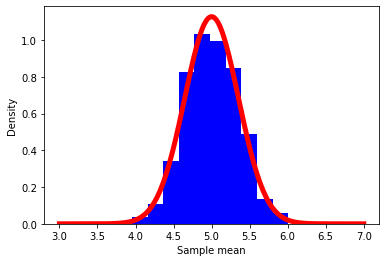

In [4]:
sample_size = 200
num_replicates = 500

sample_means = [stats.expon.rvs(scale = 5, size = sample_size).mean()
                for _ in range(num_replicates)]

plot_df = pd.DataFrame({"sample_mean": sample_means})

mesh_size = 200

x_vals = np.linspace(3, 7, num=200)

clt_scale = 5 / np.sqrt(sample_size)

clt_df = pd.DataFrame(
    {
        "x": x_vals,
        "pdf": stats.norm.pdf(x_vals, loc = 5, scale = clt_scale)
    }
)

plt.figure()
plt.hist(plot_df.sample_mean, density=True,  color="blue")
plt.plot(clt_df.x, clt_df.pdf, color="red", linewidth=5)
plt.xlabel("Sample mean")
plt.ylabel("Density")
plt.show()

### Question

Another way to assess if the sample appear to come from a normal
distribution is to use a Q-Q plot. Generate a Q-Q plot to check if the
samples appear to be normally distributed.

### Answer

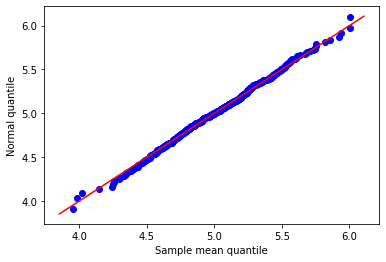

In [5]:
unit_mesh = np.linspace(
    1 - 0.5 / num_replicates,
    0.5 / num_replicates,
    num = num_replicates
)

quantile_vals = [stats.norm.isf(u, loc = 5, scale = clt_scale) for u in unit_mesh]
sample_means.sort()
quant_df = pd.DataFrame({
    "sample_means": sample_means,
    "quantiles": quantile_vals})

ab_lims = [min(sample_means)-0.1, max(sample_means)+0.1]
abline_df = pd.DataFrame({"x": ab_lims, "y": ab_lims})

plt.figure()
plt.scatter(quant_df.sample_means, quant_df.quantiles, color="blue")
plt.plot(abline_df.x, abline_df.y, color="red")
plt.xlabel("Sample mean quantile")
plt.ylabel("Normal quantile")
plt.show()

Experimental results: flipping coins in series
----------------------------------------------

Each of 15 students take turns flipping a coin 30 times and recording
how many heads they got. There is a suspicion that some of the students
did not actually do this properly. Some people think they just wrote
down some garbage and went to lunch early.

Read the data in `experiement1.csv` into a `DataFrame`.

In [6]:
exp1 = pd.read_csv("experiment1.csv")

Compute the point estimate and CI using the function you wrote above.

In [7]:
head_counts = exp1.drop(columns="flip_number").groupby("name").sum()
head_counts["name"] = head_counts.index.copy()

total_heads = int(head_counts["outcome"].sum())
num_people = int(head_counts["name"].unique().size)
num_flips = int(exp1["name"].value_counts().unique())

est_and_ci = wald_estimate_and_ci(num_success=total_heads,
                                  num_trials=num_people * num_flips)

print(est_and_ci)

(0.49333333333333335, (0.44713979693549655, 0.5395268697311701))


We estimate the probability of heads as 0.49 with a $95\%$ CI of
(0.45,0.54). We are not able to reject the null hypothesis that the coin
is fair.

### Question

Generate a histogram of the number of heads from each student. As an
extension, include the binomial distribution supported by your estimate
that is most amenable to large value outcomes.

### Answer

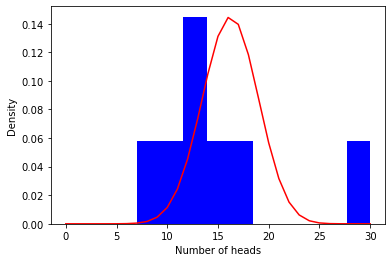

In [8]:
k_vals = range(0,30+1)
k_probs = stats.binom.pmf(k = k_vals, n = num_flips, p = 0.540)
binom_dist_df = pd.DataFrame({"value": k_vals,
                              "prob": k_probs})

plt.figure()
plt.hist(head_counts.outcome, color="blue", density=True)
plt.plot(binom_dist_df.value, binom_dist_df.prob, color="red")
plt.xlabel("Number of heads")
plt.ylabel("Density")
plt.show()

### Question

It looks like there might be a couple of strange points in this dataset
as suspected. Using the upper bound on $p$ calculate the probability of
someone getting all heads. Write a couple of sentences explaining
whether you think it is reasonable to remove those data points.

### Answer

In [9]:
stats.binom.pmf(k = 30, n = 30, p = 0.54)

9.371579521404065e-09

-   Even allowing for a high estimate of the probability of heads it
    seems unlikely that the 30 heads are genuine, hence we removed them
    from the data set prior to further analysis.

### Question

Once the questionable data has been removed, plot the distribution of
the estimated binomial distribution on top of the histogram. Write a
couple of sentences explaining what you think about the coin now.

### Answer

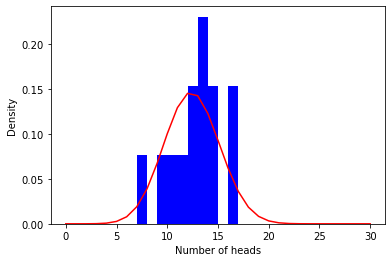

In [10]:
head_counts_clean = head_counts.loc[head_counts["outcome"] < 30]

total_heads_clean = int(head_counts_clean["outcome"].sum())
num_people_clean = int(head_counts_clean["name"].unique().size)

wald_estimate_and_ci(num_success=total_heads_clean, num_trials=num_people_clean * num_flips)

k_vals = range(0,31)
k_probs = [stats.binom.pmf(k = k, n = num_flips, p = 0.415) for k in k_vals]
binom_dist_df = pd.DataFrame({"value": k_vals,
                              "prob": k_probs})

plt.figure()
plt.hist(head_counts_clean.outcome, color="blue", density=True)
plt.plot(binom_dist_df.value, binom_dist_df.prob, color="red")
plt.xlabel("Number of heads")
plt.ylabel("Density")
plt.show()

-   After removing two outliers, we estimate the probability of heads as
    $0.42$ with a $95\%$ CI of $(0.37, 0.46)$.
-   Given the CI does not contain the value 0.5, we can reject the null
    hypothesis that the coin is fair.

Experimental results: flipping coins in parallel
------------------------------------------------

The royal mint has become interested and wants to study an additional 49
coins and repeat the experiment to gather more data about the
fascinating topic of coin bias. Now, each of 50 students is given a coin
each and asked to flip the coin 30 times and record the results.

### Question

Do we need to change anything about how we analyse this data? If so,
why, if not, why not? **Hint:** there are good arguments that can be
given for each answer. Once you have answered one way, try to answer the
other way.

### Answer

If you assume the coins have the same probability of heads it is fine.
If you assume that the coins vary then you would need to adjust the
model.

### Question

Using the data in `experiment2.csv` explore the data set using the
methodology devised above and write a couple of sentences to explain
what you found.

### Answer

In [11]:
exp2 = pd.read_csv("experiment2.csv")

head_counts = exp2.drop(columns="flip_number").groupby("name").sum()
head_counts["name"] = head_counts.index.copy()

total_heads = int(head_counts["outcome"].sum())
num_people = int(head_counts["name"].unique().size)
num_flips = int(exp2["name"].value_counts().unique())

wald_estimate = wald_estimate_and_ci(num_success=total_heads, 
                                     num_trials=num_people * num_flips)

print(wald_estimate)

(0.4013333333333333, (0.37652739859779666, 0.42613926806887))


### Question

Visualise the number of heads each student got and compare the variance
in this to what is predicted by theory.

### Answer

18.69224489795919 7.2079466666666665


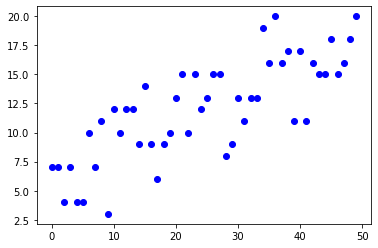

In [12]:
emp_var = head_counts["outcome"].var()
thry_var = stats.binom.var(n = num_flips, p = wald_estimate[0])
print(emp_var,thry_var)

plt.figure()
plt.scatter(head_counts.name, head_counts.outcome, color="blue")
plt.show()

-   There appears to be systematic differences in the number of heads
    obtained.
-   The variance is too great.
-   It seems that we should not consider all the coins as identical.

### Question

Consider how you might analyse this data. Over the following weeks you
will learn a couple of approaches.

### Answer

One could use a negative binomial distribution if one were interested in
an empirical analysis or a hierarchical model if one were interested in
a structural analysis.